In [13]:
from sustaingym.envs.evcharging import EVChargingEnv, GMMsTraceGenerator, DiscreteActionWrapper
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import sklearn

set new seed\
run through entire episode  (288 steps)\
save moer info

In [50]:
def timestep_to_index( ts):
    return int(np.round((ts * 60 * 24) / 5)) - 1

In [ ]:
# Create events generator which samples events from a GMM trained on Caltech
# data. The 'jpl' site is also supported, along with the periods
# 'Fall 2019', 'Spring 2020' , and 'Summer 2021'.

gmmg = GMMsTraceGenerator('caltech', 'Summer 2021')
env = EVChargingEnv (gmmg)
env =DiscreteActionWrapper(env)

obs, _ = env.reset(seed=1)
terminated = False
info_2 = {}

n_timesteps = 289
i = 0
while not terminated:
    info_2[i] = {}
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info_d = env.step(action)
    info_2[i]['a'] = action
    info_2[i]['o'] = copy.deepcopy(obs)
    # print(timestep_to_index(obs['timestep']))
    info_2[i]['r'] = reward
    info_2[i]['trunc'] = truncated
    info_2[i]['info'] = copy.deepcopy(info_d)
    
    i += 1

In [55]:
info_2[0]['o'].keys()

dict_keys(['timestep', 'est_departures', 'demands', 'prev_moer', 'forecasted_moer'])

In [38]:
np.array([5*i/(60*24) for i in range(1, int(60*24/5) + 1)]).round(10)[0]

0.0034722222

In [14]:
gmmg = GMMsTraceGenerator('caltech', 'Summer 2021')
env = EVChargingEnv (gmmg)
env =DiscreteActionWrapper(env)

errors = {}
n_seeds = 100
for seed in range(0, n_seeds):
    obs, _ = env.reset(seed=seed)
    terminated = False

    time_step = 0
    forecasts = {}
    error_d = {}
    actual_moers = []

    # forecast for t = 0
    forecasts[time_step] = obs['forecasted_moer']

    while not terminated:
        action = env.action_space.sample()
        obs, _, terminated, _, _ = env.step(action)
        actual_moers.append(obs['prev_moer'][0])
        forecasts[time_step] = obs['forecasted_moer']
        time_step += 1

    # create shifting window
    for step in range(len(actual_moers)):
        window = actual_moers[step : step + 36]
        forecast = forecasts[step]
        if len(window) < 36:
            forecast = forecast[:len(window)] # if window is shorter than 36 (for the end), align forecast
            error = window - forecast
            error = np.pad(error, (0, 36 - len(error)), mode="constant")
        else:
            error = window - forecast
        error_d[step] = error
    errors[seed] = error_d


--- Training GMMs ---

Fitting GMM (30 components, 4 dimensions) on data from caltech site from 2021-05-01 to 2021-08-31... 
Saving to: gmms/caltech/2021-05-01 2021-08-31 30.pkl

--- Training complete. ---



In [15]:
dfs = []
for seed in range(100):
    dfs.append(pd.DataFrame(errors[seed]).T)

In [17]:
ts_errors = []
for row in range(dfs[0].shape[0]):
    d = {}
    for seed in range(len(dfs)):
        d[seed] = dfs[seed].iloc[row].values
    pd.DataFrame(d).T.to_csv(f'moer_errors/by_ts/ts_{row}.csv')
    ts_errors.append(pd.DataFrame(d).T)

In [ ]:
# for making plots of errors by timestep

# for row in range(dfs[0].shape[0]):
#     d = {}
#     for seed in range(len(dfs)):
#         d[seed] = dfs[seed].iloc[row].values
#     temp = pd.DataFrame(d)
#     for col in temp:
#         plt.plot(temp[col])
#     plt.savefig(f'error_plots_by_timestep/time_step_{row}.png')
#     plt.clf()

<Figure size 640x480 with 0 Axes>

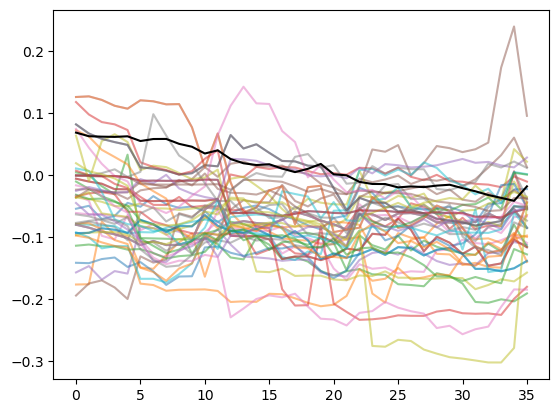

In [152]:
ts = 96

pca = sklearn.decomposition.PCA()
pca.fit(ts_errors[ts])

for row in range(len(ts_errors[ts])):
    plt.plot(ts_errors[ts].iloc[row], alpha = 0.5)
plt.plot(pca.components_[1] * np.sqrt(pca.explained_variance_[1]), color = 'black')

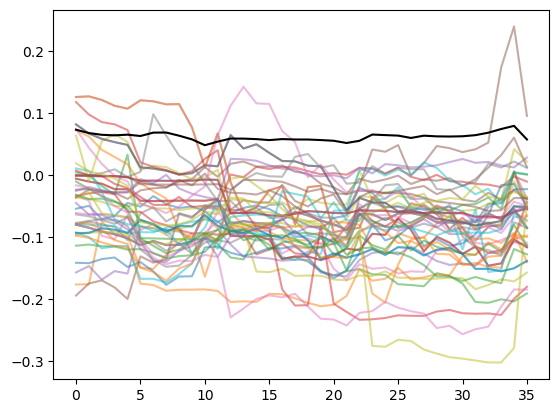

In [153]:
for row in range(len(ts_errors[ts])):
    plt.plot(ts_errors[ts].iloc[row], alpha = 0.5)
plt.plot(np.std(ts_errors[ts]), color = 'black')

In [7]:
ts_errors = pd.read_csv('moer_errors/error_std.csv', header = 0, index_col=0)
ts_errors

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.057526,0.052575,0.050024,0.049837,0.046728,0.032070,0.028098,0.026579,0.027260,0.026656,...,0.023642,0.027433,0.024870,0.022334,0.023433,0.024143,0.024870,0.023387,0.024759,0.023776
1,0.057704,0.052562,0.052125,0.048766,0.043438,0.028480,0.026485,0.027290,0.026678,0.028450,...,0.030266,0.024557,0.021680,0.024047,0.023655,0.025760,0.023144,0.024781,0.022975,0.028450
2,0.057808,0.054652,0.050959,0.045439,0.038968,0.026776,0.027260,0.026719,0.028613,0.028461,...,0.027073,0.021619,0.023284,0.023860,0.025135,0.024070,0.024364,0.022961,0.027522,0.027528
3,0.059795,0.053412,0.047678,0.040878,0.038011,0.027360,0.026659,0.028750,0.028569,0.034886,...,0.023669,0.023113,0.023168,0.025367,0.023371,0.025110,0.022722,0.027589,0.026487,0.026027
4,0.058419,0.050169,0.043080,0.040023,0.038967,0.026812,0.028765,0.028761,0.034814,0.042633,...,0.025435,0.023104,0.024691,0.023861,0.024553,0.023385,0.027102,0.026697,0.024916,0.026143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.029882,0.025941,0.016722,0.020076,0.021619,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284,0.030408,0.014229,0.017373,0.019736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
285,0.009529,0.014282,0.017095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
286,0.009497,0.013846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
error_mag_by_time = []
for i in range(len(ts_errors)):
    error_mag_by_time.append(np.linalg.norm(ts_errors[i], axis = 1).mean())

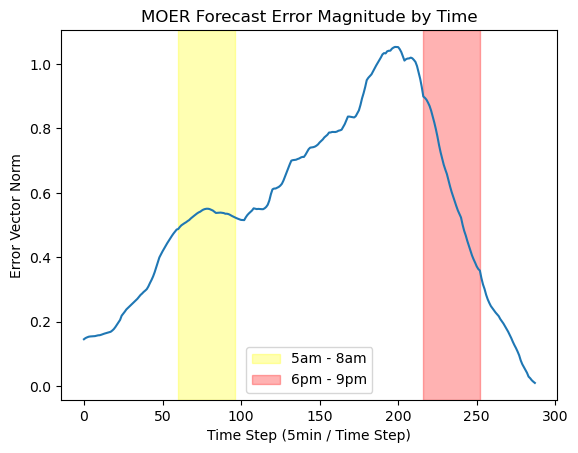

In [20]:
plt.plot(error_mag_by_time)
plt.title('MOER Forecast Error Magnitude by Time')
plt.ylabel('Error Vector Norm')
plt.xlabel('Time Step (5min / Time Step)')

# Highlight range: 5am to 7am (Timesteps 60 to 84)
plt.axvspan(60, 96, color='yellow', alpha=0.3, label='5am - 8am')

# Highlight range: 7pm to 9pm (Timesteps 234 to 252)
plt.axvspan(216, 252, color='red', alpha=0.3, label='6pm - 9pm')
plt.legend()

In [37]:
np.mean(ts_errors[0], axis = 0)

0     0.018644
1     0.015683
2     0.013394
3     0.011097
4     0.011355
5    -0.000415
6    -0.001445
7    -0.001434
8    -0.001825
9    -0.002461
10   -0.004159
11   -0.005786
12    0.001668
13    0.003334
14    0.003145
15    0.001992
16    0.000967
17   -0.000583
18   -0.001098
19   -0.001205
20   -0.001348
21   -0.002589
22   -0.002185
23   -0.002414
24    0.001334
25    0.001323
26    0.001728
27    0.002423
28    0.001518
29    0.000685
30    0.000730
31    0.000606
32    0.000150
33   -0.000350
34    0.000369
35    0.000731
dtype: float32

In [38]:
std_by_timesteps = {}
bias_by_timesteps = {}
for ts in range(len(ts_errors)):
    std_by_timesteps[ts] = np.std(ts_errors[ts]).values
    bias_by_timesteps[ts] = np.mean(ts_errors[ts], axis = 0).values

In [41]:
bias_by_timesteps

{0: array([ 0.01864401,  0.01568333,  0.01339434,  0.01109738,  0.01135538,
        -0.00041526, -0.0014448 , -0.00143355, -0.00182497, -0.00246072,
        -0.00415929, -0.00578614,  0.00166778,  0.00333368,  0.00314549,
         0.00199206,  0.00096722, -0.00058267, -0.00109772, -0.00120507,
        -0.00134826, -0.00258946, -0.0021848 , -0.00241374,  0.00133377,
         0.00132322,  0.00172764,  0.002423  ,  0.00151815,  0.00068517,
         0.00072965,  0.00060563,  0.00015034, -0.00035046,  0.00036898,
         0.00073084], dtype=float32),
 1: array([ 1.7149935e-02,  1.4578653e-02,  1.0602829e-02,  1.0319257e-02,
         6.2431139e-03, -3.8970211e-03, -3.3904081e-03, -4.0522222e-03,
        -5.2734269e-03, -4.8555359e-03, -7.6320637e-03,  1.3179782e-02,
         4.9555339e-03,  2.8969159e-03, -8.0884754e-04, -6.9765287e-04,
        -2.3404979e-03, -1.3733292e-03, -2.5574388e-03, -2.7881190e-03,
        -5.7409639e-03, -2.1660866e-03, -4.4035185e-03,  9.1069583e-03,
         1.29

In [42]:
pd.DataFrame(std_by_timesteps).T.to_csv('moer_errors/error_std.csv')
pd.DataFrame(bias_by_timesteps).T.to_csv('moer_errors/error_bias.csv')
# df = pd.read_csv('moer_errors/error_std.csv', header = 0, index_col=0)
# df.iloc[0].values

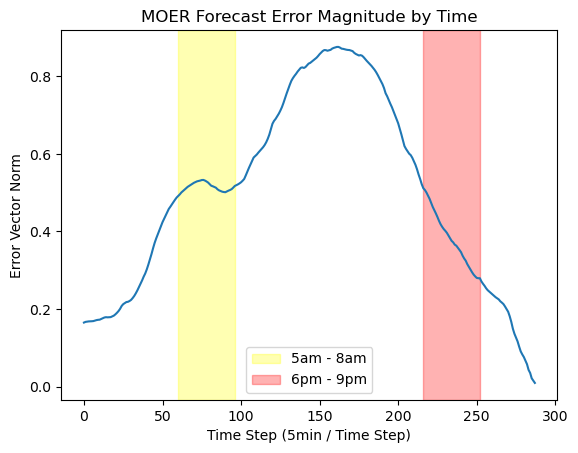

In [48]:
std_mag_by_time = []
for i in range(len(std_by_timesteps)):
    std_mag_by_time.append(np.linalg.norm(std_by_timesteps[i]).mean())

plt.plot(std_mag_by_time)
plt.title('MOER Forecast Error Magnitude by Time')
plt.ylabel('Error Vector Norm')
plt.xlabel('Time Step (5min / Time Step)')

# Highlight range: 5am to 7am (Timesteps 60 to 84)
plt.axvspan(60, 96, color='yellow', alpha=0.3, label='5am - 8am')

# Highlight range: 7pm to 9pm (Timesteps 234 to 252)
plt.axvspan(216, 252, color='red', alpha=0.3, label='6pm - 9pm')
plt.legend()

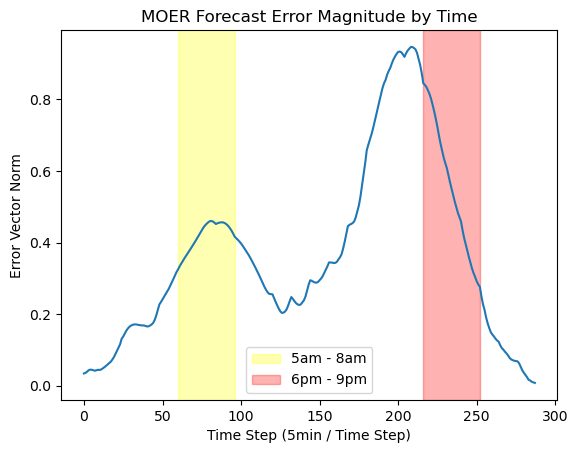

In [47]:
bias_mag_by_time = []
for i in range(len(bias_by_timesteps)):
    bias_mag_by_time.append(np.linalg.norm(bias_by_timesteps[i]).mean())

plt.plot(bias_mag_by_time)
plt.title('MOER Forecast Error Magnitude by Time')
plt.ylabel('Error Vector Norm')
plt.xlabel('Time Step (5min / Time Step)')

# Highlight range: 5am to 7am (Timesteps 60 to 84)
plt.axvspan(60, 96, color='yellow', alpha=0.3, label='5am - 8am')

# Highlight range: 7pm to 9pm (Timesteps 234 to 252)
plt.axvspan(216, 252, color='red', alpha=0.3, label='6pm - 9pm')
plt.legend()

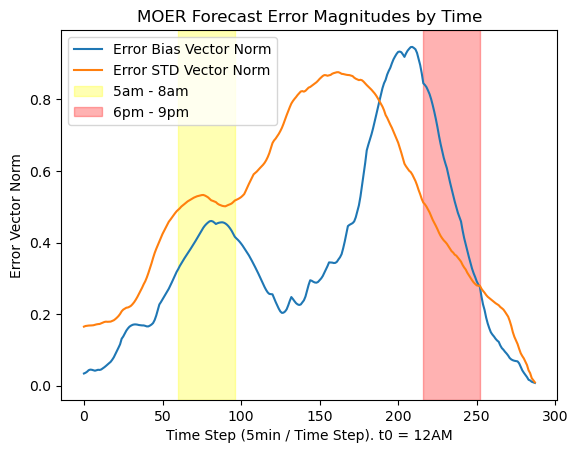

In [ ]:
plt.plot(bias_mag_by_time, label = 'Error Bias Vector Norm')
plt.plot(std_mag_by_time, label = 'Error STD Vector Norm')
plt.title('MOER Forecast Error Magnitudes by Time')
plt.ylabel('Error Vector Norm')
plt.xlabel('Time Step (5min / Time Step). t0 = 12AM')

# Highlight range: 5am to 7am (Timesteps 60 to 84)
plt.axvspan(60, 96, color='yellow', alpha=0.3, label='5am - 8am')

# Highlight range: 7pm to 9pm (Timesteps 234 to 252)
plt.axvspan(216, 252, color='red', alpha=0.3, label='6pm - 9pm')
plt.legend()

